# Using MELD to characterize chordin loss-of-function
## Introduction

In this tutorial, we will demonstrate how to use MELD to characterize the effect of Cas9-mutagenesis in the zebrafish embryo. We will use a dataset generated by the Klein and Megason labs and published in [Wagner et al. (2018) (doi: 10.1126/science.aar4362)](https://www.ncbi.nlm.nih.gov/pubmed/29700229). Here, zebrafish embryos were injected with Cas9 + gRNAs at the one-cell stage targeting either chordin (*chd*) in the experimental condition or tyrosinase (*tyr*) in the control condition. Embryos were collected in a rough time course from 14-16 hours post fertilization for scRNA-seq and 27,000 cells were recovered.

[Chordin](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CHRD) is a BMP antagonist required for proper specification of dorsally-derived neural tissues ([Hammerschmidt et al. 1997](https://www.ncbi.nlm.nih.gov/pubmed/9007232)). [Tyrosinase](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TYR) is a gene required for melanin production, but does not affect cell type specification at the time points considered in this study.

Here, we will use MELD to quantify the effect of the mutation as was done in the [MELD manuscript](https://doi.org/10.1101/532846) and generate all of the figures described in Sections 2.6 and 2.7.

We will also introduce some basics of preprocessing, visualization and imputation to give an idea of how you might include MELD in a general scRNA-seq analysis workflow.

Here's the order we'll follow:

* [1. Loading the dataset](#1.-Loading-data)  
* [2. Filtering, normalizing, and transforming the data](#2.-Filtering,-normalizing,-and-transforming-the-data)
* [3. Embedding Data Using PHATE](#3.-Embedding-Data-Using-PHATE)
* [4. Using MELD to calculate sample-associated density estimates and likelihood](#4.-Using-MELD-to-calculate-sample-associated-density-estimates-and-relative-likelihood)
* [5. Using VFC to subcluster each published cluster](#5.-Using-VFC-to-subcluster-each-published-cluster)
* [6. Isolating the Tailbud-Presomitic Mesoderm cluster](#6.-Isolating-the-Tailbud---Presomitic-Mesoderm-cluster)

## 0. Installing packages

If you haven't installed MELD yet, you can do so from this notebook. We'll also install some other useful packages while we're at it.

In [1]:
!pip install --user meld phate magic-impute cmocean diffxpy seaborn

## 1. Loading data

### 1.1 Downloading and importing data from GEO
We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).

Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

**Standard imports**


In [2]:
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
import cmocean
import sklearn
import scipy
import seaborn as sns

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# making sure plots & clusters are reproducible
np.random.seed(42)

%load_ext autoreload
%autoreload 2

import diffxpy.api as de

/home/dan/.local/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(0)

#### Use `scprep.io.load_csv` to import all three matrices into a DataFrame for each sample (this may take a few minutes)¶

This data is available from [GEO Series GSE112294](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE112294). Note, the entire dataset is roughly 50MB. We will load it directly into this notebook from the web.

Note: By default, `scprep.io.load_csv` loads scRNA-seq data using the Pandas SparseDataFrame [(see Pandas docs)](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_csv`. We are passing a URL as the filename, but you can also use this function to load data already stored on your computer.

Note: There are many helper functions available for loading single cell data in `scprep.io`. Learn more in [the `scprep.io` documentation](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.io).

In [4]:
sample_info = [('GSM3067201', 'chd', 'A'), ('GSM3067202', 'chd', 'B'), ('GSM3067203', 'chd', 'C'),
           ('GSM3067204', 'tyr', 'A'), ('GSM3067205', 'tyr', 'B'), ('GSM3067206', 'tyr', 'C')]
counts_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
             'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}' \
             '.csv.gz'
clusters_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
               'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}_' \
               'clustID.txt.gz'
cluster_names_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE112nnn/GSE112294/' \
                    'suppl/GSE112294_ClusterNames.csv.gz'

In [5]:
sparse = True
counts_matrices = [] 
batch_labels = []
metadata = []
for accession, genotype, replicate in sample_info:
    curr_label = '{}{}'.format(genotype, replicate)
    print('Downloading {accession}.{genotype}.{replicate} ...'.format(accession=accession, genotype=genotype, replicate=replicate))
    
    batch_labels.append(curr_label)
    
    data = scprep.io.load_csv(counts_url.format(accession=accession, genotype=genotype, replicate=replicate),
                              sparse=sparse, cell_axis='column')
    counts_matrices.append(data)
    
    clusters = scprep.io.load_csv(clusters_url.format(accession=accession, genotype=genotype, replicate=replicate),
                       cell_names=data.index, gene_names=['clusterID'], sparse=sparse)
    metadata.append(clusters)

data, sample_labels = scprep.utils.combine_batches(counts_matrices, batch_labels, append_to_cell_names=True)
metadata, _ = scprep.utils.combine_batches(metadata, batch_labels, append_to_cell_names=True)
data.head()

,LOC100000009,LOC100000024,LOC100000058,LOC100000086,LOC100000094,LOC100000098,LOC100000110,LOC100000119,LOC100000140,LOC100000155,...,zte38,zufsp,zw10,zwi,zwilch,zyg11,zymnd12,zyx,zzef1,zzz3
DEW193_TGGGAATT_AGAGACTA_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEW193_TATCTGTC_CTTCGCAC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEW193_AGGGTAAA_AAAGCCTA_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
DEW193_CCCGTTCT_GCTTTGGC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
DEW193_CCAGACAG_TGGGATTC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Adding the sample labels to the `metadata` DataFrame

We will store all additional information about the cells (e.g. sample labels referring to which batch they were in, cluster IDs, and more) in the `metadata` data frame. This will make it easier to subset the metadata when we filter the counts matrix.

In [6]:
counts_matrices.clear() #to save space
metadata['sample_labels'] = sample_labels
metadata.head()

,clusterID,sample_labels
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA


In [7]:
metadata['genotype'] = ['chd' if label.startswith('chd') else 'tyr' for label in metadata['sample_labels']]

### Importing published cluster assignments

Now we will load the file that maps clusterIDs (which are `int`s) to cluster names (which are `str`s)

In [8]:
ClusterNamesMaps = scprep.io.load_csv(cluster_names_url, cell_names=False).set_index("ClusterID")
ClusterNamesMaps.head()

/home/dan/.local/lib/python3.8/site-packages/scprep/sanitize.py:51: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  warnings.warn(


,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,04hpf-blastocyst - EVL
1.2,4,04hpf-blastocyst - margin
1.3,4,04hpf-blastocyst - DEL
1.4,4,04hpf-blastocyst - germline
2.0,6,06hpf-non-dorsal margin


We're not interested in having the time points at the start of the cluster name. Fortunately, all of these time points are exactly six characters long, so we can remove them with `pandas` handy string slice method. 

In [9]:
ClusterNamesMaps['ClusterName'] = ClusterNamesMaps['ClusterName'].str.slice(6)
ClusterNamesMaps.head()

,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,blastocyst - EVL
1.2,4,blastocyst - margin
1.3,4,blastocyst - DEL
1.4,4,blastocyst - germline
2.0,6,non-dorsal margin


Now we can select the cluster name corresponding to each cell's cluster ID.

In [10]:
cluster_names = ClusterNamesMaps['ClusterName'].loc[metadata['clusterID']]
cluster_names.index = metadata.index
metadata['cluster'] = cluster_names
metadata.head()

,clusterID,sample_labels,genotype,cluster
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA,chd,hatching gland
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA,chd,differentiating neurons - rohon beard
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA,chd,tailbud - PSM
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA,chd,tailbud - PSM
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA,chd,tailbud - PSM


## 2. Filtering, normalizing, and transforming the data

### Filtering

We filter the data by:

1. Removing dead cells
2. Filtering by library size
3. Removing genes that are expressed in relatively few cells.

### Filtering cells by library size and filtering genes with low detection

#### Removing lowly detected genes
Here, we'll use `filter_rare_genes` to remove genes detected in fewer than 10 cells. We lack sufficient information about these genes to make inferences about their gene expression.

In [11]:
data = scprep.filter.filter_rare_genes(data)

#### Library size

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the <1% of cells that have very high library sizes.

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/histogram.py:156: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("symlog", linthreshx=abs_min)


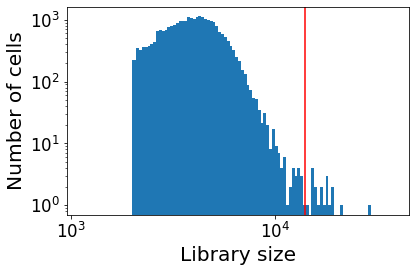

In [12]:
scprep.plot.plot_library_size(data, cutoff=15000);

We can use `scprep.filter` for various filtering tasks. Here, we'll use `filter_library_size` to keep cells below a cutoff of 10,000 UMI/cell.

In [13]:
data, metadata = scprep.filter.filter_library_size(
    data, metadata, cutoff=15000, 
    keep_cells='below')

#### Removing cells with small library size and abnormal expression
During preliminary analysis, a group of 24 cells were identified originating exclusively from the chd embryos. Despite an average library size in the bottom 12% of cells, these cells exhibited 546-fold, 246-fold, and 1210-fold increased expression of Sh3Tc1, LOC101882117, and LOC101885394 respectively. To the best of our knowledge, the function of these genes in development is not described. These cells were excluded from further analysis.

The cell barcodes of these cells are stored in 'excluded_cells.txt'

<AxesSubplot:xlabel='Gene expression', ylabel='Number of cells'>

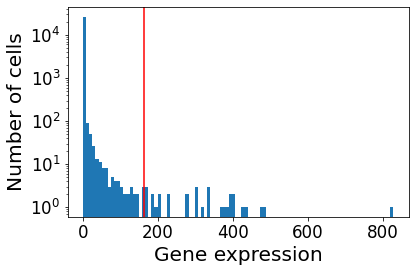

In [14]:
scprep.plot.plot_gene_set_expression(data, genes=['LOC101885394'], log='y', cutoff=164)

In [15]:
data, metadata = scprep.filter.filter_gene_set_expression(data, metadata, genes=['LOC101885394'], cutoff=164)

### Library size normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In `scprep` this is performed using the `normalize` method `library_size_normalize()`.

In [16]:
data_libnorm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

In [17]:
metadata['library_size'] = libsize
metadata.head()

,clusterID,sample_labels,genotype,cluster,library_size
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA,chd,hatching gland,12786.0
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA,chd,differentiating neurons - rohon beard,5267.0
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA,chd,tailbud - PSM,4438.0
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA,chd,tailbud - PSM,4054.0
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA,chd,tailbud - PSM,3559.0


### Square root transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log{0}$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

There are a number of transformations implemented in [`scprep.transform`](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.transform).

In [18]:
data_sqrt = np.sqrt(data_libnorm)

### Examining the number of cells in each sample past filtering



First, we create a colormap for visualizating the samples. You can select colors by hex code with Google's [RGB color picker](https://www.google.com/search?client=firefox-b-1-d&q=rgb+color+picker).

In [19]:
sample_cmap = {'chdA' : '#fb6a4a',
                'chdB' : '#de2d26',
                'chdC' : '#a50f15',
                'tyrA' : '#6baed6',
                'tyrB' : '#3182bd',
                'tyrC' : '#08519c'}

As we can see in the following plot, there are many more cells that passed QC in the chdA condition relative to the other samples. To account for this, the MELD algorithm automatically normalizes each replicate to account for varying numbers of cells.



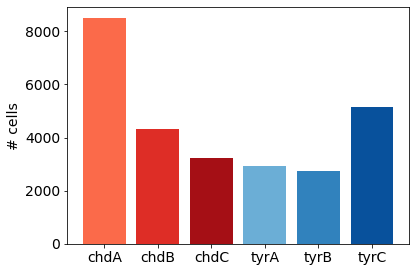

In [20]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(metadata['sample_labels'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c, color=sample_cmap[groups[i]])
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

## 3. Embedding Data Using PHATE

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.


Here's the simplest way to apply PHATE:
```python
phateop = phate.PHATE(knn=9, decay=10, gamma=0, n_jobs=-2)
Y = phateop.fit_transform(data_sq)
```

In [21]:
data_pca = scprep.reduce.pca(data_sqrt)

phate_op = phate.PHATE(knn=10, decay=10, n_jobs=-1)
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 26827 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 25.29 seconds.
    Calculating affinities...
    Calculated affinities in 55.01 seconds.
  Calculated graph and diffusion operator in 82.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 33.92 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.87 seconds.
  Calculated landmark operator in 53.14 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.33 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.44 seconds.
Calculated PHATE in 141.18 seconds.


### Coloring a PHATE plot by sample ID

And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

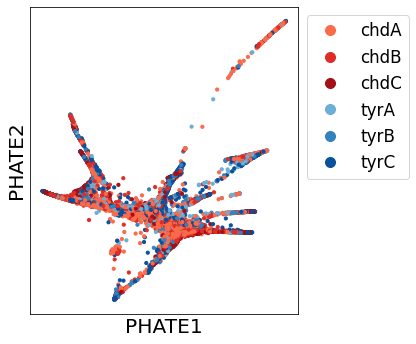

In [22]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], cmap=sample_cmap, 
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring a PHATE plot by ClusterIDs

In Wagner et al. (2018), cells from the *chd* and *tyr* conditions were assigned cluster IDs through projection back to a reference dataset. In the published analysis, these number of cells mapping to each cluster in the *chd* vs *tyr* condition was used at the measure of *chd* loss-of-function on that cluster. To visualize the relationships between these clusters, we will color the PHATE plot by each cell's published ClusterID.

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/utils.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

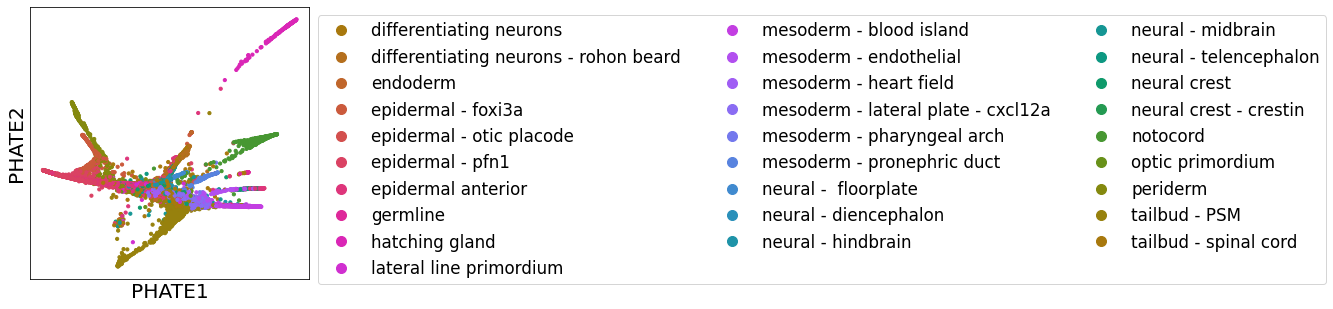

In [23]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'], cmap=cmocean.cm.phase, 
                      legend_anchor=(1,1), figsize=(5,5), s=10, label_prefix='PHATE', ticks=False)

### Interpreting the PHATE plot

Examining this PHATE plot, we see observe a complex many-branched structure. We can see that each region or branch of the PHATE plot is enriched for various clusters. However, you may notice that there are some clusters that occupy several branches of the plot. This is one of the issues with clustering - it is not perfect and the diversity within each cluster may not be uniform across clusters.

## 4. Using MELD to calculate sample-associated density estimates and relative likelihood

Using MELD, we quantify the effect of an experimental perturbation by first estimating the density of each sample over a graph learned from all cells from all samples. This yields one density estimate per sample. We then normalize density estimates across samples from the same replicate to calculate the sample-associated relative likelihood. This relative likelihood is a ratio between the sample probability densities from each condition and indicates how much more likely we are to observe a given cell in one condition relative to another. 

We can use the relative likelihood estimates to identify which cells are the most enriched in each experimental condition and which cell types are unchanging across conditions. We can also use this value to identify the gene signature of a perturbation (*i.e.* the genes that change the most across experimental conditions).

#### Separating replicate and conditions

We run the MELD algorithm on each sample independently, then normalize within each replicate. First we're going to create a vector that indicated the replicate that each cell was sequenced in.

In [24]:
metadata['genotype'] = [1 if sl.startswith('chd') else 0 for sl in metadata['sample_labels']]
metadata['genotype_name'] = ['chd' if g == 1 else 'tyr' for g in metadata['genotype']]
metadata['replicate'] = [sl[-1] for sl in metadata['sample_labels']]

### (Optional) Parameter search

As noted in our manuscript, the optimal filter and graph parameters for the MELD algorithm can vary with dataset size and structure. To select parameters automatically, we added a framework to generate many random signals over a dataset and calculate the accuracy of the MELD algorithm with different graph and filter parameters.

The base unit of this parameter search is the `meld.Benchmarker()` class. The basic workflow of the benchmarker class is as follows:

1. Generate a random conditional density over the data (PDF)
2. Randomly assign cells to an `expt` and `ctrl` condition based on the PDF
3. Run the MELD algorithm on the data using user-specific parameters
4. Calculate the Mean Square Error (MSE) between the sample-associated relative likelihood for the `expt` condition and the ground-truth PDF

We then repeat these steps a number of times for each set of parameters and compare the MSE of the outputs. The lowest average MSE is the optimal set of parameters for downstream analysis.

In [ ]:
benchmarker = meld.Benchmarker()

# 3D PHATE components are used to create the ground truth PDF
benchmarker.fit_phate(data_pca);

Let's plot three random PDFs

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, ax in enumerate(axes):
    benchmarker.generate_ground_truth_pdf()
    scprep.plot.scatter2d(data_phate, c=benchmarker.pdf, cmap=meld.utils.get_meld_cmap(),
                     vmin=0, vmax=1, ticks=False, ax=ax)
    
fig.tight_layout()

Next, we import a library to run the parameter search in parallel. I'm writing this tutorial on a server with 36 cores and I'd like to use them! If you haven't used joblib before, it's a really handy library for taking `for` loops and turning them into parallel operations. Read more: https://joblib.readthedocs.io/en/latest/

Note, the following parameter search takes more than 12 hours on a 36 core server. You could speed up the process by running a more coarse grained parameter search (set the `step` parameter in the `np.arange` calls below) and then run a more fine tuned search once you've narrowed the set of parameters that have the best performance.

For the purposed of this tutorial, you can also just load the results of the parameter search by skipping the to "Loading Parameter Search Results" code block.

In [ ]:
from joblib import Parallel, delayed

def simulate_pdf_calculate_likelihood(benchmarker, seed, beta):
    benchmarker.set_seed(seed)
    benchmarker.generate_ground_truth_pdf()
    
    benchmarker.generate_sample_labels()
    benchmarker.calculate_MELD_likelihood(beta=beta)
    MELD_mse = benchmarker.calculate_mse(benchmarker.expt_likelihood)
    return MELD_mse, seed, beta, benchmarker.graph.knn

In [ ]:
knn_range = np.arange(1,25)
beta_range = np.arange(1,200)

In [ ]:
results = []

with Parallel(n_jobs=36) as p:
    for knn in knn_range:
        # doing this outside the parallel loop because building the graph takes the longest
        benchmarker.fit_graph(adata.X, knn=knn)
        print(knn)
        curr_results = p(delayed(simulate_pdf_calculate_likelihood)(benchmarker, seed, beta) \
                                       for seed in range(25) for beta in beta_range)
        curr_results = pd.DataFrame(curr_results, columns = ['MSE', 'seed', 'beta', 'knn'])
        results.append(curr_mse)

results = pd.concat(results, axis=0)

### Loading Parameter Search Results

Since the above code takes a long time to run, we can also download the results.

In [25]:
import os, tempfile

URL = 'https://github.com/KrishnaswamyLab/MELD/blob/master/data/Klein_parameter_search_results.pickle.gz?raw=true'

with tempfile.TemporaryDirectory() as tempdir:
        filepath = os.path.join(tempdir, "parameter_search_results.pickle.gz")
        scprep.io.download.download_url(URL, filepath)
        results = pd.read_pickle(filepath)

# We want to take the average of each set of random seeds for each combination of beta and knn values
results_wide = results.groupby(['beta', 'knn']).mean().sort_values(by='MSE').reset_index()

We can use a scatterplot to visualize the results of the parameter search. Here, brighter colors are mapped to lower Mean Squared Error and thus correspond to higher accuracy.

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


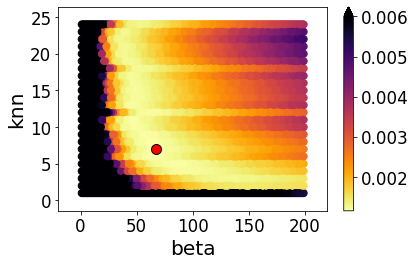

In [26]:
ax = scprep.plot.scatter(results_wide['beta'], results_wide['knn'], 
                         s=50, c=results_wide['MSE'], vmax=0.006, cmap='inferno_r')

# Highlight the top performing combination with a large red dot
top_result = results_wide.sort_values('MSE').iloc[0]
ax.scatter(top_result['beta'], top_result['knn'], c='r', s=100, linewidth=1, edgecolor='k')

This is the best set of parameters on average.

In [27]:
top_result

beta    67.000000
knn      7.000000
MSE      0.001162
seed    12.000000
Name: 0, dtype: float64

Based on the above plots, we can see that the optimal results are achieved with `knn=7` and `beta=67`.

### Run MELD

These next two code blocks build the graph for MELD and estimate the density of each sample.

In [28]:
G = gt.Graph(data_pca, knn=int(top_result['knn']), use_pygsp=True)

In [29]:
meld_op = meld.MELD(beta=top_result['beta'])
sample_densities = meld_op.fit_transform(G, sample_labels=metadata['sample_labels'])

Building graph on 26827 samples and 100 features.


Next, we normalize the densities for each sample to calculate the likelihood of the chordin condition per replicate

In [30]:
def replicate_normalize_densities(sample_densities, replicate):
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        curr_cols = sample_densities.columns[[col.endswith(rep) for col in sample_densities.columns]]
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(sample_densities[curr_cols], norm='l1')
    return sample_likelihoods

In [31]:
sample_likelihoods = replicate_normalize_densities(sample_densities, metadata['replicate'])

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


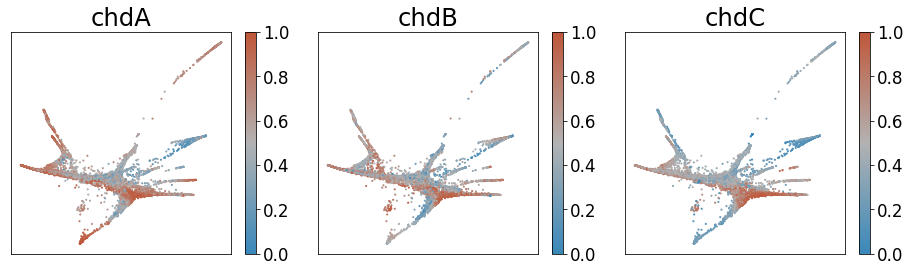

In [32]:
fig, axes = plt.subplots(1,3, figsize=(13,4))

experimental_samples = ['chdA', 'chdB', 'chdC']

for i, ax in enumerate(axes):
    curr_sample = experimental_samples[i]
    scprep.plot.scatter2d(data_phate, c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                          vmin=0, vmax=1,
                          title=curr_sample, ticks=False, ax=ax)

fig.tight_layout()

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(
/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


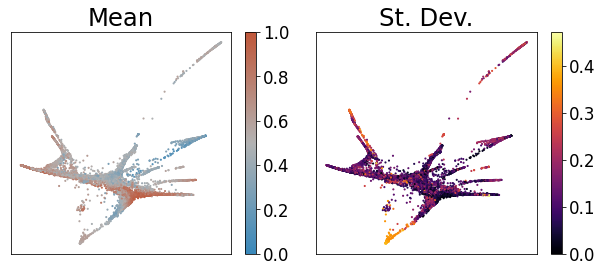

In [33]:
fig, axes = plt.subplots(1,2, figsize=(8.7,4))

scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].mean(axis=1), 
                      cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                      title='Mean', ticks=False, ax=axes[0])
scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                      cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

fig.tight_layout()

We use the average likelihood of the chordin samples as the measure of the perturbation.

In [34]:
metadata['chd_likelihood'] = sample_likelihoods[experimental_samples].mean(axis=1).values

### Examining the distribution of _chd_ likelihood values in published clusters

In [35]:
sample_cmap = {'chdA': '#fb6a4a',
                 'chdB': '#de2d26',
                 'chdC': '#a50f15',
                 'tyrA': '#6baed6',
                 'tyrB': '#3182bd',
                 'tyrC': '#08519c'}



Let's sort the index of each cluster from lowest to highest average _chd_ likelihood value

In [36]:
metadata['clusterID'] = scprep.utils.sort_clusters_by_values(metadata['clusterID'], metadata['chd_likelihood'])

#### Create jitter plots

These show the distribution of _chd_ likelihood values within each cluster. Each point is a cell and the y-axis is the _chd_ likelihood. The slight jitter in the x-xais is  only to help show density within each cluster.

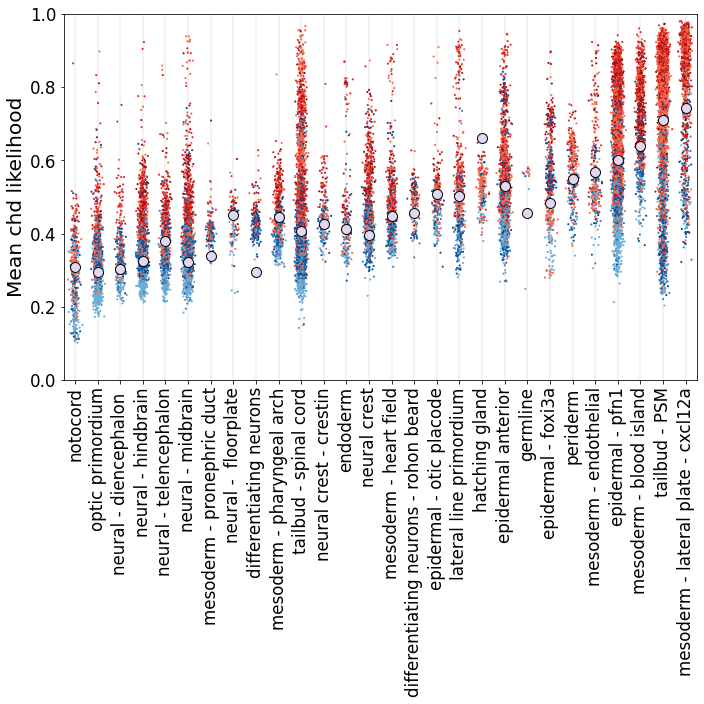

In [37]:
fig, ax = plt.subplots(1, figsize=(10,10))

# See example usage: https://scprep.readthedocs.io/en/stable/examples/jitter.html
scprep.plot.jitter(metadata['clusterID'], metadata['chd_likelihood'], c=metadata['sample_labels'], 
                   cmap=sample_cmap,legend=False, plot_means=False, xlabel=False, ylabel='Mean chd likelihood',
                   ax=ax)

### This code will plot the ratio of tyr:chd cells per cluster
means = metadata.groupby('clusterID')['genotype'].mean()
ax.scatter(means.index, means - np.mean(metadata['genotype']) + 0.5, color='#e0d8f0', edgecolor='k', s=100)

# Axis tick labels
ax.set_xticklabels(metadata.set_index('clusterID')['cluster'].drop_duplicates().sort_index(), rotation=90)
ax.set_ylim(0,1)

fig.tight_layout()

####  Interpreting the plot

Here, we can see the distribution of _chd_ likelihood values for each cell organized by the clusterID assigned by Wagner et al. (2018). Due to the issues with clustering above, we see that some clusters contain "outliers." For example, in the cluster on the far left, "optic primordium", has an average _chd_ likelihood value of around -0.28, indicating that these cells are generally more prototypical in the tyrosinase condition. This is consisten with the observed reduced head size in *chd* mutant zebrafish (See Wanger et al. 2018 for a thorough description of the mutant phenotype). However, there are also some cells with very high _chd_ likelihood values, and a couple with values around 0.55. This is a result of the clustering assigning the same cluster label to cells that are not adjacent on the cell similarity graph. 

This problem is especially apparent with the `tailbud - spinal cord` and `tailbud - PSM`* populations where the range of _chd_ likelihood values in each group is especially large. In the MELD publication, we focued on the tailbud - presomitic mesoderm population. So let's start there.

\*(PSM = presomitic mesoderm)

## 5. Using VFC to subcluster each published cluster


Here, we're going to select and arbitrary cutoff that we only want to consider clusters that have at least 1% of the data for further clustering. For this dataset, that means we'd consider clusters with >268 cells.

In [38]:
# Get cluster indicides and number of cells per cluster
clusters, counts = np.unique(metadata['clusterID'], return_counts=True)

# Keep cluster labels with at least 1% of the data
clusters = clusters[counts > data.shape[0] * 0.01]

#### Visualize each cluster using PHATE

Here, we want to visualize the heterogeneity within each cluster using PHATE run on each dataset. If the PHATE embedding shows multiple groups of cells with different _chd_ likelihood values (as in cluster 26, for example) we can reason that this cluster might need further subsclustering using VFC.

In [39]:
data_cluster_phate = {}

for cluster in clusters:
    curr_data = data_pca.loc[metadata['clusterID'] == cluster]
    data_cluster_phate[cluster] = phate.PHATE(verbose=0).fit_transform(curr_data)

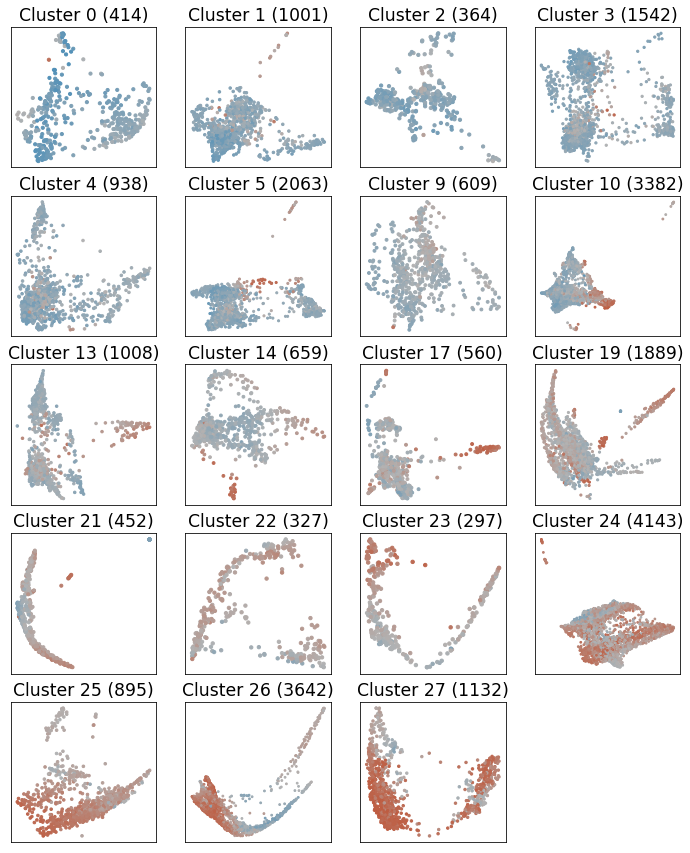

In [40]:
fig,axes= plt.subplots(5,4, figsize=(4*3, 5*3))

for i , ax in enumerate(axes.flatten()):
    if not i < len(clusters):
        ax.axis('off')
        continue
    curr_cluster = clusters[i]
    curr_phate = data_cluster_phate[curr_cluster]
    
    scprep.plot.scatter2d(curr_phate, 
                          c=metadata['chd_likelihood'].loc[metadata['clusterID'] == curr_cluster], 
                          cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                         ax=ax, ticks=False, 
                          title='Cluster {} ({})'.format(curr_cluster, curr_phate.shape[0]), 
                          legend=False, fontsize=10)

#### Build a VFC operator for each cluster

Next, we want to examine the differences between the results of VFC clustering at different numbers of clusters. The goal here is to make sure that the results of the clustering align with the grouping of cells we observe in the PHATE plots and the distribution of likelihood values.

In [41]:
np.random.seed(0)
vfc_op_per_cluster = {}

for cluster in np.unique(metadata['clusterID']):
    curr_G = gt.Graph(data_pca.loc[metadata['clusterID'] == cluster], use_pygsp=True)
    curr_G.compute_fourier_basis()
    curr_sample_labels = metadata['genotype'].loc[metadata['clusterID'] == cluster]
    curr_likelihood = metadata['chd_likelihood'].loc[metadata['clusterID'] == cluster]
    curr_vfc = meld.VertexFrequencyCluster(n_clusters = 3)
    curr_vfc.fit_transform(curr_G, curr_sample_labels, curr_likelihood)
    vfc_op_per_cluster[cluster] = curr_vfc

2020-11-30 14:42:39,849:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3382 x 3382) may take some time.
2020-11-30 14:42:53,942:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4143 x 4143) may take some time.
2020-11-30 14:43:08,930:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3642 x 3642) may take some time.


In [42]:
subclustering_results = {}
for cluster in np.unique(metadata['clusterID']):
    curr_vfc = vfc_op_per_cluster[cluster]
    clusters_by_n = {}
    for n in [2,3,4,5]:
        clusters_by_n[n] = curr_vfc.predict(n)
    subclustering_results[cluster] = clusters_by_n

I've already looked through the clusters and determined which number of clusters look best to me. The results are stored in the following dictionary

In [43]:
picked_clusters = {
    4:3,  8:3, 15:3, 17:2, 18:3, 
    22:3, 24:3, 25:3, 26:4, 27:5}

Now we're going to plot the results of all of the VFC clustering results. This produces a very long figure, but it's worth looking at each of the plots individually. We don't claim that the cluster values we selected are "correct" because there's no clear objective we're targeting here. Take cluster 11, for example. Perhaps we should have looked at 5 clusters here to more closely match the structure observed in the embedding. To dive more deeply, one could perform differential expression testing between the 5 clusters to see if the heterogeneity in the visualization is biologically relevant.

The red boxes indicate the clustering that we selected.

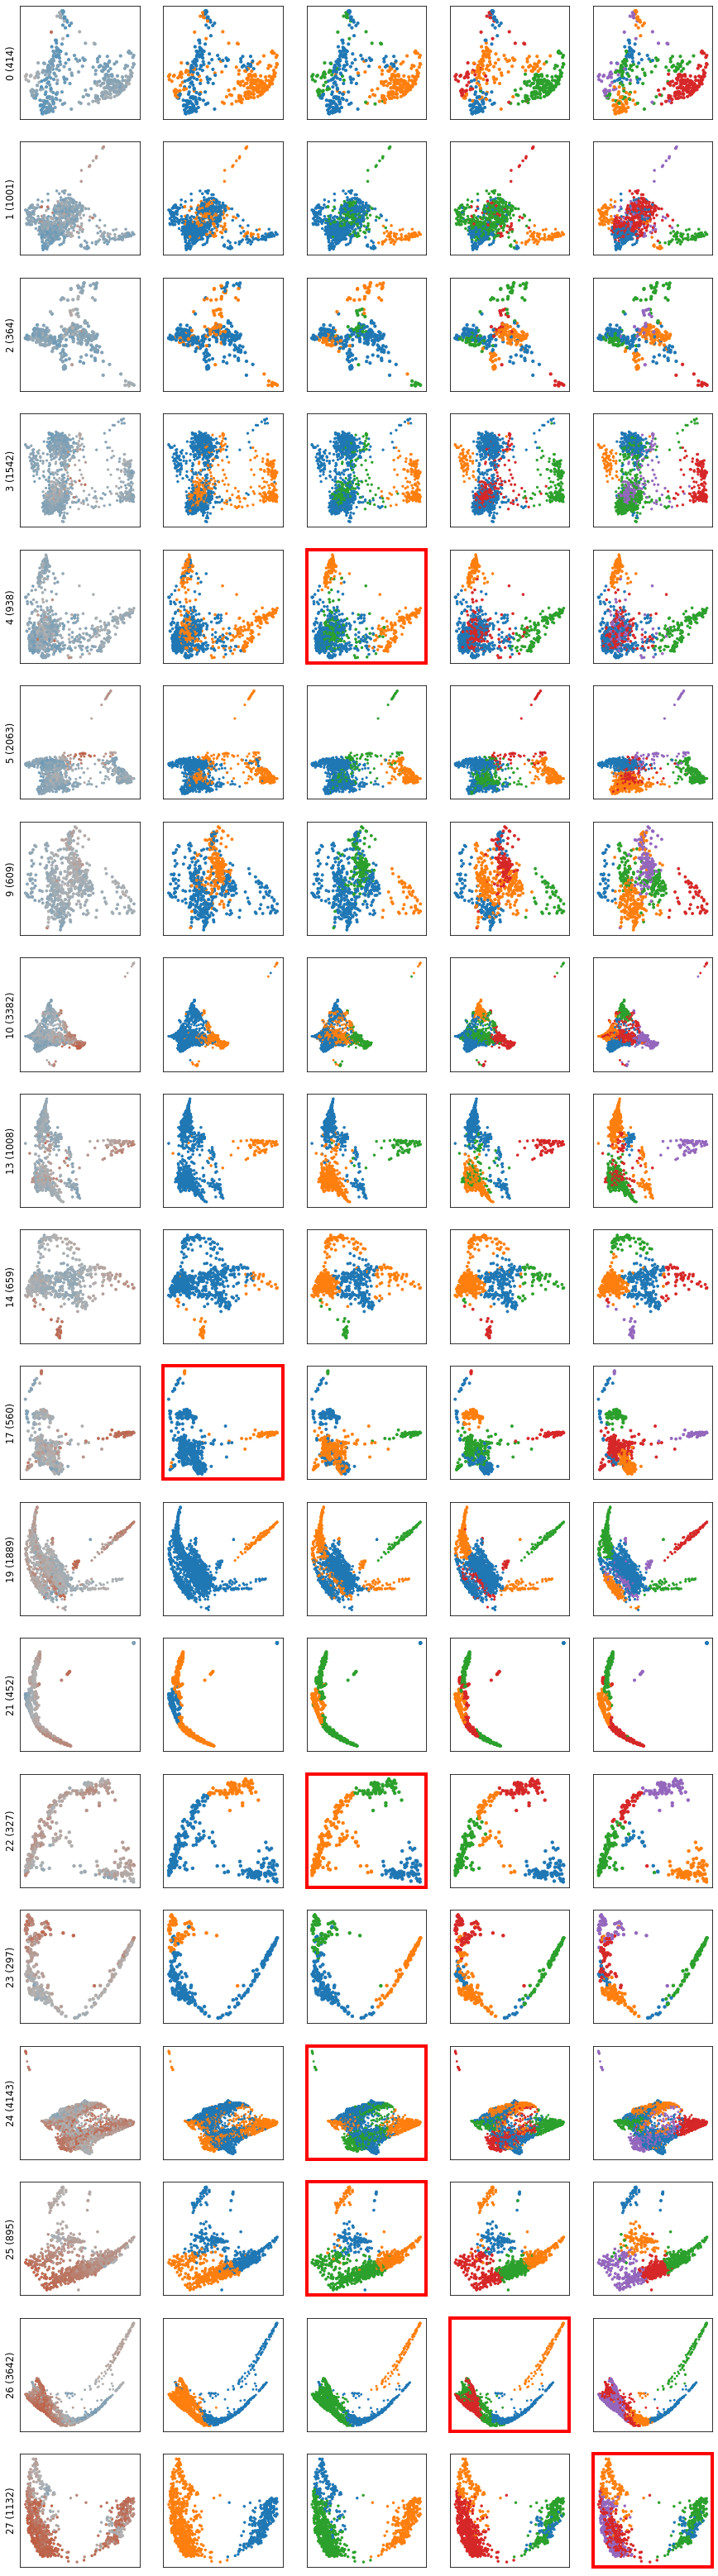

In [44]:
fig, axes= plt.subplots(19,5, figsize=(15, 19*3))

for i, r_ax in enumerate(axes):
    cluster = clusters[i]
    curr_phate = data_cluster_phate[cluster]

    for i, n in enumerate([0,2,3,4,5]):
        if i == 0:
            cvec = metadata['chd_likelihood'].loc[metadata['clusterID'] == cluster]
            ylabel= str(cluster) + ' ({})'.format(len(cvec))

            cmap= meld.get_meld_cmap()
            vmin=0
            vmax=1           
        else:
            cvec = subclustering_results[cluster][n]
            cmap = ylabel = vmin = vmax = None
            
        if np.sum(metadata['clusterID'] == cluster) < (metadata.shape[0] * 0.01):
            plt.setp(r_ax[i].spines.values(), color='lightgrey', linewidth=4)
        scprep.plot.scatter2d(curr_phate, c=cvec, cmap=cmap, vmin=vmin, vmax=vmax,
                         ax=r_ax[i], ticks=False, ylabel=ylabel, fontsize=8, legend=False)
        # Red outline for clusters that we decide to subcluster
        if cluster in picked_clusters:
            if picked_clusters[cluster] == n:
                plt.setp(r_ax[i].spines.values(), color='r', linewidth=4)

Now let's actually break up the clusters using the VFC results and create a new jitter plot.

In [45]:
metadata['VFC'] = metadata['clusterID'].copy()
for curr_cluster in clusters:
    if curr_cluster not in picked_clusters:
        continue
    
    new_clusters = subclustering_results[curr_cluster][picked_clusters[curr_cluster]]
    
    metadata.loc[metadata['clusterID'] == curr_cluster, 'VFC'] = new_clusters + 1 + np.max(metadata['VFC'])
metadata['VFC'] = scprep.utils.sort_clusters_by_values(metadata['VFC'], metadata['chd_likelihood'])

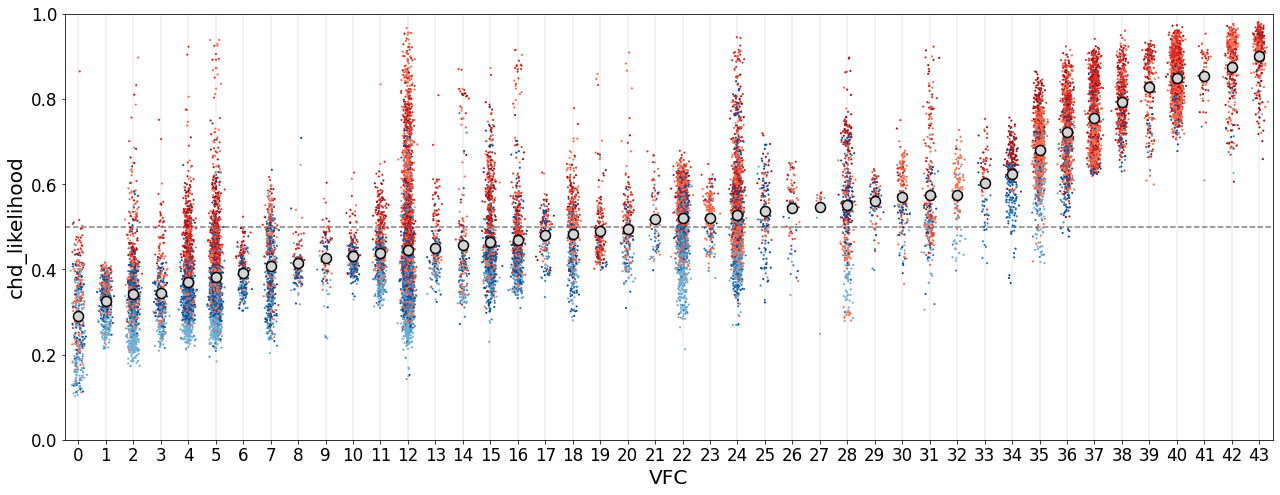

In [46]:
ax = scprep.plot.jitter(metadata['VFC'], metadata['chd_likelihood'], c=metadata['sample_labels'],
                        cmap=sample_cmap, figsize=(18,7), legend=False)
ax.set_ylim(0,1)
ax.axhline(0.5, linestyle = '--', color='grey', zorder=0)

## 6. Isolating the Tailbud - Presomitic Mesoderm cluster

Next, we will create a mask on the data to zero in on the cells corresponding to the `tailbud - presomitic mesoderm` cluster and visualize these cells using PHATE.

### Data denoising using MAGIC

In [47]:
marker_genes = ['aldh1a2', 'cdx4', 'foxd3', 'fsta', 'gata2a', 'lmo2', 'meox1',
       'myl10', 'myod1', 'myog', 'ntd5', 'ripply1', 'sox2', 'ta', 'tal1',
       'tbx6', 'wnt8a']
data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 26827 cells and 29197 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 42.23 seconds.
    Calculating KNN search...
    Calculated KNN search in 72.35 seconds.
    Calculating affinities...
    Calculated affinities in 72.55 seconds.
  Calculated graph and diffusion operator in 188.43 seconds.
  Calculating imputation...
  Calculated imputation in 0.05 seconds.
Calculated MAGIC in 191.49 seconds.


/home/dan/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [48]:
# Subset data from this cluster
curr_cluster = 26
curr_cluster_data = data.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_cluster_data_magic = data_magic.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_cluster_metadata = metadata.loc[np.isin(metadata['clusterID'], curr_cluster)].copy()
curr_data_phate = data_cluster_phate[curr_cluster]

### Plotting the TPM cluster using PHATE

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

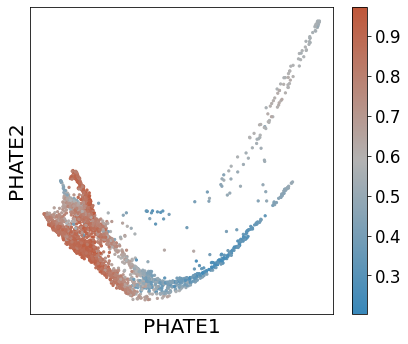

In [49]:
scprep.plot.scatter2d(curr_data_phate, c=curr_cluster_metadata['chd_likelihood'], cmap=meld.get_meld_cmap(), 
                      figsize=(6,5), s=5, label_prefix="PHATE", ticks=False)

####  Interpreting the PHATE plot

Looking at this plot, we observe several branching structures in the data, indicating that there are probably multiple cell types within the `tailbud - PSM`. Furthermore, we can see that the likelihood values within these cells are not uniformly distributed on the PHATE plot. In fact, some regions of the plot are enriched for high likelihood values and other are enriched for low values. From this, we can hypothesize that the wide range of likelihoods in the `tailbud - PSM` is due to multiple cell types within this group that each exhibit different responses to *chd* loss-of-function.

### Vertex Frequency Clustering

To handle this problem, we developed a method called **vertex frequency clustering**. The algorithm is described in the MELD manuscript, but the goal of this algorithm is to indentify cells that are both 1) transcriptionally similiar and 2) exhibit uniform responses to the experimental perturbation. The algorithm is implemented in the `meld.VertexFrequencyCluster` class. 

This class works similarly to the `sklearn` clustering classes, and all it needs is the graph `G`, the `sample_labels` and the `chd_likelihood` to create a matrix called the spectrogram. Currently, we use `KMeans` to do clustering on the spectrogram, so you must set `k`. Picking `k` is an imperfect science. We arrived at `k=4` for this dataset after trying several numbers of clusters and inspecting the expression of previously characterized marker genes for tissues in the zebrafish embryo.

Note that we set the random seed here, since `KMeans` does not produce the same output every time.

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

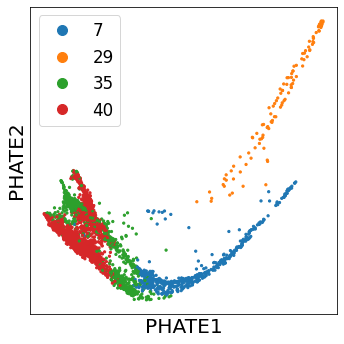

In [50]:
scprep.plot.scatter2d(curr_data_phate, c=curr_cluster_metadata['VFC'], 
                      figsize=(5,5), s=5, label_prefix="PHATE", ticks=False)

<AxesSubplot:xlabel='VFC', ylabel='chd_likelihood'>

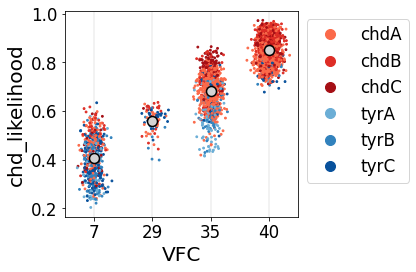

In [51]:
scprep.plot.jitter(curr_cluster_metadata['VFC'], curr_cluster_metadata['chd_likelihood'], 
                   c=curr_cluster_metadata['sample_labels'], cmap=sample_cmap,
                  legend_anchor=(1,1))

### Characterizing clusters by marker genes

#### Assigning cluster names

Now that we know what cell type is in each cluster, we can assign labels to each group.

To start, lets load a dataframe of marker genes by tissue we created using the supplementary notes from [Farrell et al. (2018)](https://doi.org/10.1126/science.aar3131).

In [52]:
gist_url = 'https://gist.githubusercontent.com/dburkhardt/ba7784b0eee9bece76be1719485ea571/' \
           'raw/607fdae74e52ab31a22baf29532072330ac62ba8/farrell_larval_zebrafish_marker_genes.csv'
marker_genes = pd.read_csv(gist_url)
marker_genes['gene'] = [g.lower() for g in marker_genes['gene']]

#### Differential expression within clusters

Next we perform differential expression analysis using [diffxpy](https://github.com/theislab/diffxpy/) to identify genes that differentiate each subcluster.

Perform differential expression for each subcluster vs all other cells in the TPM cluster

In [53]:
subcluster_marker_genes = {}
# Iterate over VFC subclusters
for curr_subcluster in np.unique(curr_cluster_metadata['VFC']):
    # Create mask for current subcluster
    is_curr_subcluster = curr_cluster_metadata['VFC'] == curr_subcluster
    
    # Rank test comparing each subcluster to all other cells in cluster
    curr_de_results = de.test.two_sample(curr_cluster_data.values, 
                                         gene_names = data.columns, 
                                         grouping=is_curr_subcluster,
                                         test='rank').summary()
    
    # P and Q values may be artificially inflated when subclustering
    # so we keep only top 1% of differentially expressed genes 
    # see https://doi.org/10.1016/j.cels.2019.07.012 for more info
    top_genes = curr_de_results.sort_values('qval').loc[curr_de_results['qval'] < 0.05, 'gene'].values
    
    # Get a list of DE genes that are also marker gene
    curr_marker_genes = []
    for gene in top_genes[:230]:
        if gene in marker_genes['gene'].values:
            curr_marker_genes.append(gene)
    subcluster_marker_genes[curr_subcluster] = curr_marker_genes

This plot shows both the relative expression level (color) and relative differential expression (size of dot) for each cluster and gene. The subtissue annotations on the right side of the plot come from the annotation by Farrell et al. (2018). This makes it easier to annotate each cluster.

<ipython-input-54-e8b9403a3a9b>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_markers = np.unique(np.hstack(subcluster_marker_genes.values()))


<AxesSubplot:xlabel='Cluster'>

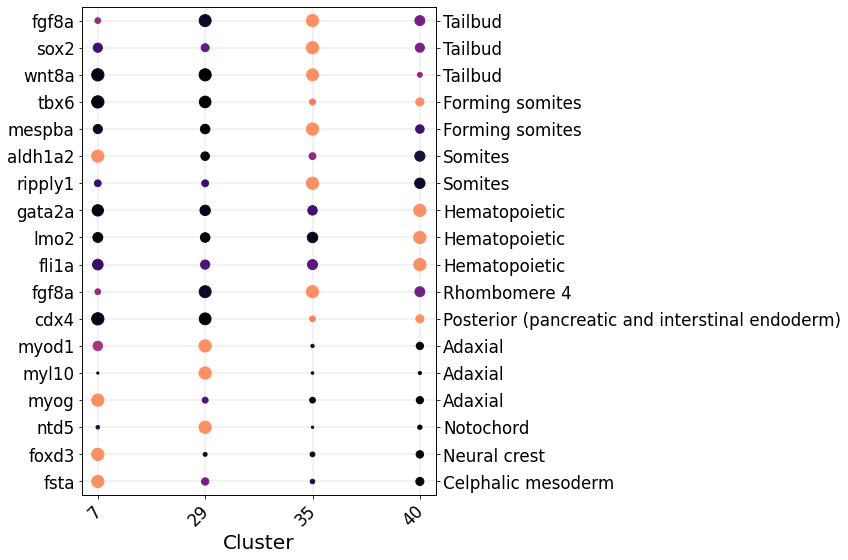

In [54]:
all_markers = np.unique(np.hstack(subcluster_marker_genes.values()))
curr_marker_genes = marker_genes.loc[np.isin(marker_genes['gene'], all_markers), ['subtissue', 'gene']]
curr_marker_map = {}
for subtissue in curr_marker_genes['subtissue'].unique():
    curr_marker_map[subtissue] = curr_marker_genes.loc[curr_marker_genes['subtissue'] == subtissue, 'gene'].values

# Although gata2a and fli1a are not in the farrell list, I saw lmo2 was expressed in this tissue and 
# found other markers of hematopoietic cells in https://doi.org/10.1002/wdev.312
curr_marker_map['Hematopoietic'] = ['lmo2', 'gata2a', 'fli1a']

scprep.plot.marker_plot(data=curr_cluster_data.values,
                        gene_names=curr_cluster_data.columns,
                        clusters=curr_cluster_metadata['VFC'], 
                        markers=curr_marker_map,
                        figsize=(12,8))

Now we can assign labels to each cluster

In [55]:
tpm_cluster_markers = ['myog', 'foxd1', 'myod1', 'wnt8a', 'gata2a']
max_expression = curr_cluster_data.groupby(curr_cluster_metadata['VFC'])[tpm_cluster_markers].mean().idxmax()

In [56]:
label_map = {max_expression.loc['myod1'] : 'Adaxial - mature',
             max_expression.loc['myog']  : 'Adaxial - immature',
             max_expression.loc['wnt8a'] : 'Presomitic mesoderm',
             max_expression.loc['gata2a'] : 'Hematopoietic'}
cluster_labels = [label_map[cl] for cl in curr_cluster_metadata['VFC']]
pal = sns.color_palette('PuBu', 6)

cluster_cmap = {label_map[cl]:pal[i+1] for i, cl in enumerate(np.unique(curr_cluster_metadata['VFC']))}

And now we can recreate that plot with the proper labels and colors

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

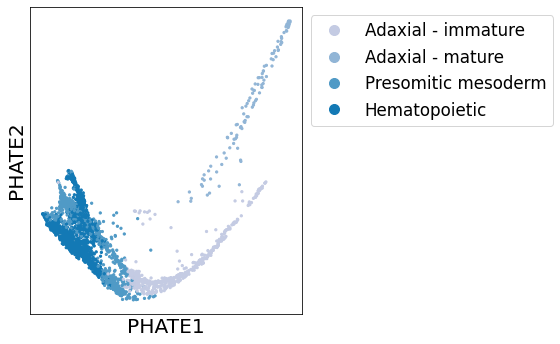

In [57]:
scprep.plot.scatter2d(curr_data_phate, c=cluster_labels, cmap=cluster_cmap,
                      figsize=(8,5), s=5, label_prefix="PHATE", ticks=False, 
                      legend_anchor=(1,1))

### Inspecting expression changes between conditions in the full cluster vs in VFC clusters

One of the advantages of VFC is that it makes it possible to identify clusters that are uniformly affected by the perturbation. This means that we expect differential expression of genes between conditions within VFC clusters to be minimal. Here, we're going to plot a kernel density estimate of MAGIC denoised values for each condition within the full cluster and within VFC clusters.

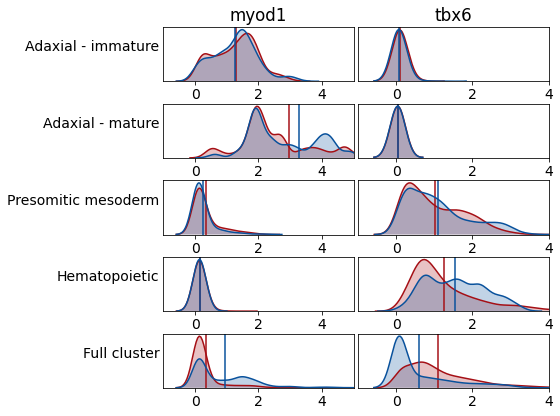

In [58]:
fig, axes = plt.subplots(5,2, figsize=(8,6))

# Two important marker genes for adaxial cells (myod1) and presomitic mesoderm cells (tbx6)
genes = ['myod1', 'tbx6']
for j, curr_gene in enumerate(genes):
    col_axes = axes[:,j]
    for i, ax in enumerate(col_axes.flatten()):
        exp = {}
        if i < 4:
            # Plot expression for the VFC clusters
            curr_cluster = np.unique(curr_cluster_metadata['VFC'])[i]
            ylabel = label_map[curr_cluster]
            curr_cluster_mask = curr_cluster_metadata['VFC'] == curr_cluster
            
            for geno_name in ['chd', 'tyr']:
                curr_cond_mask  = curr_cluster_metadata['genotype_name'] == geno_name
                curr_exp_cond = curr_cluster_data_magic.loc[(curr_cluster_mask) & (curr_cond_mask), curr_gene]
                
                exp[geno_name] = curr_exp_cond
                color = sample_cmap[geno_name + 'C']
                
                sns.kdeplot(curr_exp_cond, ax=ax, legend=False, color=color, shade=True, clip=[0,5], bw=0.2)
                ax.axvline(np.mean(curr_exp_cond), color=color)
            
        else:
            # Plot expression for the cluster as a whole
            for geno_name in ['chd', 'tyr']:
                ylabel = 'Full cluster'
                curr_exp = curr_cluster_data_magic.loc[curr_cluster_metadata['genotype_name'] == geno_name, curr_gene]
                color = sample_cmap[geno_name + 'C']
                exp[geno_name] = curr_exp_cond
                sns.kdeplot(curr_exp, ax=ax, legend=False, color=color, shade=True, clip=[0,5], bw=0.2)
                ax.axvline(np.mean(curr_exp), color=color)
                
        if j == 0:
            ax.set_ylabel(ylabel, rotation=0, ha='right')
        if i == 0:
            ax.set_title(curr_gene)
            
        lim_map = {'myod1':(-1,5), 'tbx6':(-1,4)}
        ax.set_xlim(lim_map[curr_gene])
        ax.set_yticks([])
        
fig.tight_layout(h_pad=.1, w_pad=.1)


#### Interpreting this plot

Here, we can see that the wide range of _chd_ likelihood values in the `tailbud - PSM` tissue is due to the presence of multiple cell types with different responses to chordin mutagenesis. In fact, the depletion of the adaxial/myotomal cells (indicated by lower _chd_ likelihood values) in chordin mutants is well documented  as is the expansion of the presomitic and somitic tissues (PMID: [9007232](https://www.ncbi.nlm.nih.gov/pubmed/9007232); [10581032](https://www.ncbi.nlm.nih.gov/pubmed/10581032)).

The main takeaway is that for most of the cases, the differences in expression for these genes is either driven by a change in number of subpopulations that respond uniformly to perturbation (as in Myod1) or that the change is restricted to a set of subclusters (as for tbx6). In both cases, VFC analysis provides deeper insight into the effect of the experimental perturbation.